In [1]:
import numpy as np
import pandas as pd
import h5py
import torch

from CommonFun import model_eva
# mymodel
from config import config as cfg
from layers.mergeBlock import mergeBlock1 as mergeBlock
from AEGAN import AE

# pysteps
from pysteps import nowcasts
from pysteps.motion.lucaskanade import dense_lucaskanade
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
from matplotlib import rcParams

plt.rcParams['font.sans-serif'] = ['SimHei']  ###防止无法显示中文并设置黑体
plt.rcParams['axes.unicode_minus'] = False  ###用来正常显示负号

TimesSong = FontProperties(fname="C:\\Users\\林子扬\\Desktop\\TimesSong.ttf")
font_manager.fontManager.addfont("C:\\Users\\林子扬\Desktop\\TimesSong.ttf")

# 全局设置字体及大小，设置公式字体即可
config = {
    "mathtext.fontset":'stix',
    "font.family":'serif',
    "font.serif": ['TimesSong'],
    'axes.unicode_minus': False, # 处理负号，即-号
    "font.size": 12
}

rcParams.update(config)

Pysteps configuration file found at: C:\Users\林子扬\pysteps\pystepsrc



In [2]:
bilv = [0.1, 0.3, 0.3, 0.3]
# 模型参数
input_channels = 1
output_channels = 1
time_steps = 5
forecast_steps = 10
batch_size = 10
output_shape = 128

dataset = h5py.File(cfg().datatest, 'r')
dataset = dataset['train']
# 数据读取和预处理
def datapre(st, ed, dataset=dataset):
    train_data = torch.zeros(batch_size, 15, 4, 128, 128)
    train_data[:, :, :, 13:114, 13:114] = torch.Tensor(dataset[st:ed, :, :, :, :])
    # train_data[:, :, :, 13:114,13:114] = torch.Tensor(dataset[10:batch_size+10, :, :, :, :])
    train_data = train_data * 95 / 255 - 10
    train_data = torch.swapaxes(train_data, 0, 1)
    train_data = (train_data[:, :, 0, :, :] * bilv[0] +
                  train_data[:, :, 1, :, :] * bilv[1] +
                  train_data[:, :, 2, :, :] * bilv[2] +
                  train_data[:, :, 3, :, :] * bilv[3]).reshape(
        15, batch_size, 1, output_shape, output_shape)

    inputx = train_data[:5, :, :, :, :].to(cfg().device)
    y = train_data[5:, :, :, :, :].to(cfg().device)
    return train_data,inputx, y  # T | B | C | H | W

In [3]:
tdata=datapre(0,10)

In [4]:
def compute_data(dataarray,huinum):
    return np.where(dataarray[:,:,0,:,:]>=huinum,1,0).sum(axis=(0,2,3))/np.where(dataarray[:,:,0,:,:]>0,1,0).sum(axis=(0,2,3))

In [5]:
# 训练集
trainfenbu=np.zeros((10000))
count=0
for data_i in [cfg().datatrain1,cfg().datatrain2]:
    dataset = h5py.File(data_i, 'r')
    dataset = dataset['train']
    for i in range(0,4991,10):
        trainfenbu[count:count+10]=compute_data(datapre(i,i+10,dataset)[0],20)
        count+=10

In [6]:
trainfenbu20=trainfenbu

In [7]:
# 测试集
testfenbu=np.zeros((2000))
count=0
dataset = h5py.File(cfg().datatest, 'r')
dataset = dataset['train']
for i in range(0,1991,10):
    testfenbu[count:count+10]=compute_data(datapre(i,i+10,dataset)[0],20)
    count+=10

In [8]:
# 验证集
yanzfenbu=np.zeros((2000))
count=0
dataset = h5py.File(cfg().datayanzeng, 'r')
dataset = dataset['train']
for i in range(0,1991,10):
    yanzfenbu[count:count+10]=compute_data(datapre(i,i+10,dataset)[0],20)
    count+=10

In [9]:
def fen2list(trainfenbu20,num):
    return [(trainfenbu20<=0.25).sum()/num,((trainfenbu20<=0.5) & (trainfenbu20>0.25)).sum()/num,((trainfenbu20<=0.75) & (trainfenbu20>0.5)).sum()/num,(trainfenbu20>0.75).sum()/num]

In [10]:
train_set=fen2list(trainfenbu20,10000)
test_set=fen2list(testfenbu,2000)
yanz_set=fen2list(yanzfenbu,2000)

In [29]:
def drawbars(ax,a,xloc):
    color=['#f6d39f','#ec9e6e','#da5f42','#ab3639']
    color=['#77DAE6','#7BBBE8','#7E9DE9','#8382EB']
    ax.barh(xloc,a[0],height=0.2,color=color[0])
    ax.barh(xloc,a[1],left=a[0],height=0.2,color=color[1])
    ax.barh(xloc,a[2],left=a[0]+a[1],height=0.2,color=color[2])
    ax.barh(xloc,a[3],left=a[0]+a[1]+a[2],height=0.2,color=color[3])
def drawbars1(ax,a,xloc):
    color=['#f6d39f','#ec9e6e','#da5f42','#ab3639']
    color=['#77DAE6','#7BBBE8','#7E9DE9','#8382EB']
    ax.barh(xloc,a[0],height=0.2,color=color[0],label='$x\leqslant 25\\%$')
    ax.barh(xloc,a[1],left=a[0],height=0.2,color=color[1],label='$25\\%<x \leqslant 50\\%$')
    ax.barh(xloc,a[2],left=a[0]+a[1],height=0.2,color=color[2],label='$50\\% x \leqslant 75\\%$')
    ax.barh(xloc,a[3],left=a[0]+a[1]+a[2],height=0.2,color=color[3],label='$x>75\\%$')

D:\Temp\ipykernel_23004\3095410688.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0','0.2','0.4','0.6','0.8','1'])


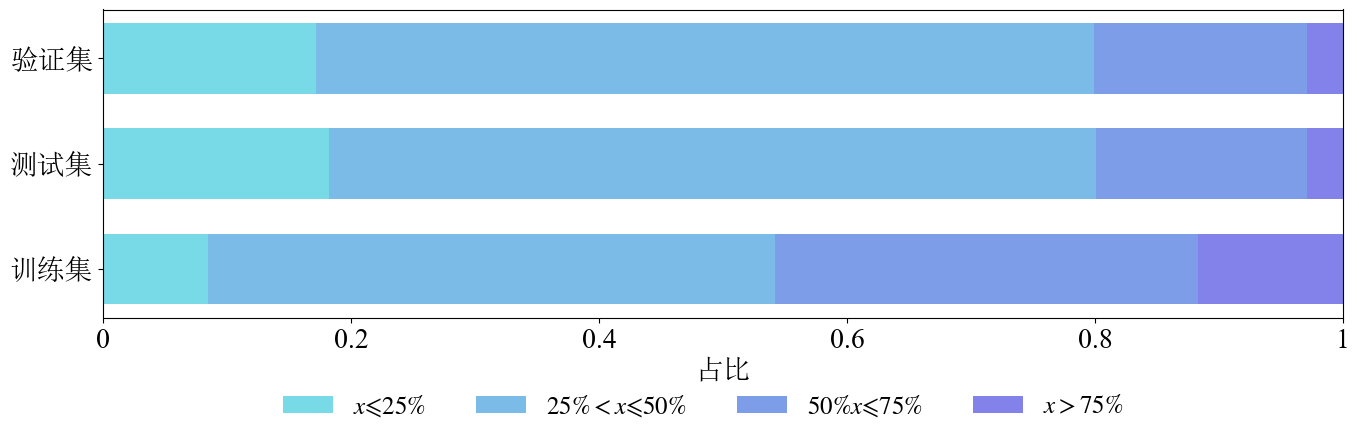

In [30]:
fig=plt.figure(figsize=(16,4))
ax=fig.subplots(1,1)
drawbars1(ax,train_set,0)
drawbars(ax,test_set,0.3)
drawbars(ax,yanz_set,0.6)

# ax.text(test_set[0]-0.155,-0.016,str(test_set[0]))
# ax.text(test_set[1],-0.016,str(test_set[1]))
# ax.text(test_set[2],-0.016,str(test_set[2]))
# ax.text(test_set[3]+0.8,-0.016,str(test_set[3]))
ax.set_yticks([0,0.3,0.6])
ax.set_yticklabels(['训练集','测试集','验证集'])
ax.tick_params(labelsize=20)
ax.set_xlabel('占比',size=20)
ax.set_xticklabels(['0','0.2','0.4','0.6','0.8','1'])
ax.set_xlim(0,1)
fig.legend(loc = 'lower center',ncol=4,frameon = False,bbox_to_anchor=(0.5, -0.2),prop = {'size':18})
plt.savefig('D:\\_毕业论文\\毕业论文\\picture\\myfenbu.png',dpi=300,bbox_inches='tight')